# Mammalia-Macaque-Dominance Network

Laura Silvana Alvarez Luque - Daniel Losada Molina


The aim of this project is to do a complete analysis of a network of interest. This includes: the network description, modeling through different techniques and results that can be obtained.

The selected network contains the dominance relations between *Macaca fuscata* females that were determined based on approach-retreat episodes around the food. The dominance range order was arranged based on these dyadic relations. Dominance is defined as "Physical contact unique to aggressive dominance interactions such as biting, head butting, fighting"

- **Vertices:** 62 Macaques.
- **Edges:** 1.167 edges representing the pairwise dominance between macaques.
- **Weights:** Frequency of the dominance.
- **Notes:**  This is a animal interation network, undirected and weighted.

![Macaca Fuscata](./imgs/Macaca.png)


In [23]:
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import igraph as ig
import plotly.graph_objects as go
import networkx as nx

from collections import Counter

# Functions

In [30]:
def unzip_file(zip_path, extract_to):
    """
    Unzip a file from zip_path into the extract_to directory.
    """
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

def plot_simple_graph(g):
    # Layout for node positions
    layout = g.layout("fr")  # Fruchterman-Reingold (force-directed)

    # Plot using igraph's built-in plot function
    ig.plot(
        g,
        layout=layout,
        vertex_label=g.vs.indices,  # show node indices
        edge_width=[w for w in g.es["weight"]],
        bbox=(800, 800),
        margin=50
    )

def plotly_graph(g):    
    # Convert to NetworkX
    G_nx = g.to_networkx()

    # Get layout positions
    pos = nx.spring_layout(G_nx)

    # Prepare edge lines
    edge_x = []
    edge_y = []
    for u, v in G_nx.edges():
        x0, y0 = pos[u]
        x1, y1 = pos[v]
        edge_x += [x0, x1, None]
        edge_y += [y0, y1, None]

    edge_trace = go.Scatter(
        x=edge_x,
        y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines',
        showlegend=False
    )

    # Create "hover points" at edge midpoints
    edge_hover_x = []
    edge_hover_y = []
    edge_text = []

    for u, v, data in G_nx.edges(data=True):
        x0, y0 = pos[u]
        x1, y1 = pos[v]
        edge_hover_x.append((x0 + x1) / 2)
        edge_hover_y.append((y0 + y1) / 2)
        weight = data.get("weight", 1)
        edge_text.append(f"{u} — {v}<br>weight: {weight}")

    edge_hover_trace = go.Scatter(
        x=edge_hover_x,
        y=edge_hover_y,
        mode='markers',
        hoverinfo='text',
        text=edge_text,
        marker=dict(size=5, color='rgba(0,0,0,0)'),  # invisible
        showlegend=False
    )

    # Prepare node positions
    node_x = []
    node_y = []
    node_text = []
    for node in G_nx.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        node_text.append(f"Node {node}")

    node_trace = go.Scatter(
        x=node_x,
        y=node_y,
        mode='markers+text',
        text=[str(n) for n in G_nx.nodes()],
        textposition='top center',
        hoverinfo='text',
        marker=dict(
            size=10,
            color='lightblue',
            line_width=1
        )
    )

    # Combine everything
    fig = go.Figure(
        data=[edge_trace, edge_hover_trace, node_trace],
        layout=go.Layout(
            title='Dominance Network of Macaques',
            showlegend=False,
            hovermode='closest',
            margin=dict(b=20, l=5, r=5, t=40),
            xaxis=dict(showgrid=False, zeroline=False),
            yaxis=dict(showgrid=False, zeroline=False)
        )
    )

    fig.show()

def get_weights_of_path(g, path):
    """
    Given a path, return the weights of the edges along that path.
    """
    original_weights = []
    inv_weights = []

    for i in range(len(path) - 1):
        source = path[i]
        target = path[i + 1]

        # Get edge ID between consecutive vertices
        edge_id = g.get_eid(source, target)

        # Extract weights
        w = g.es[edge_id]["weight"]
        iw = g.es[edge_id]["inv_weight"]

        original_weights.append(w)
        inv_weights.append(iw)

    # Print results
    print("Original weights on path:", original_weights)
    print("Inverted weights on path:", inv_weights)


def plot_degree_distribution(g, title="Degree Distribution", weighted=False):
    """
    Computes degrees (weighted or unweighted), plots their distribution,
    and returns degree info including max degree and corresponding vertex/vertices.
    """
    # Choose between weighted and unweighted degree
    if weighted:
        degrees = g.strength(weights=g.es["weight"])
    else:
        degrees = g.degree()

    # Compute degree distribution
    unique_degrees, counts = np.unique(degrees, return_counts=True)
    probabilities = counts / counts.sum()

    # Plot the distribution
    plt.figure(figsize=(8, 5))
    plt.scatter(unique_degrees, probabilities, color='black')  # Dots
    plt.vlines(unique_degrees, 0, probabilities, color='blue', alpha=0.6)  # Lines

    # Labels and title
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.title(title)

    # Show plot
    plt.show()

    # Get max degree and vertex/vertices
    max_degree = max(degrees)
    vertices_with_max = [v.index for v, d in zip(g.vs, degrees) if d == max_degree]

    # Return degrees and distribution if needed later
    return degrees, unique_degrees, probabilities, max_degree, vertices_with_max

 
 

# 1. Input data

In [4]:
unzip_file('./mammalia-macaque-dominance.zip', './data')

In [8]:
#%%capture
g = ig.Graph.Read_Ncol("data/mammalia-macaque-dominance.edges", weights=True, directed=False)
print(g.summary())


IGRAPH UNW- 62 1167 -- 
+ attr: name (v), weight (e)


In [6]:
#plotly_graph(g)

![Macaca Fuscata](./imgs/Graph.png)


In [11]:
order = g.vcount()
size = g.ecount()

print(f"The order of the network is: {order} (vertices)")
print(f"The size of the network is: {size} (edges)")

The order of the network is: 62 (vertices)
The size of the network is: 1167 (edges)


We are dealing with a highly connected graph, as we can see by the edge-vertex ratio:

$ \frac{|E|}{|V|} = \frac{1167}{62} \approx 18.82 $

This means that in average, we have 18.82 edges per vertex. That's why is not surprising to find that we only have one big component that contains all vertices. Also for this reason, we don't have any subnetwork of interest and all the analysis will be done in the whole network.

In [17]:
components = g.components()
print(f"Number of subnetworks: {len(components)}")

Number of subnetworks: 1


Due to the nature of our data, loops make no sense, as the edges represent interaction between two individuals. Anyways we check that our data has zero edges with same source and target.

In [32]:
sum(g.is_loop())

0

With the degree distribution we can check that the network is highly connected as we saw previously. It does not have the clasical decreasing distribution starting in small degree values, instead, it starts in 14 and seems to have a bimodal distribution with concentrations around 34 and 44. Also, the most conected vertex is the 29 with 55 edges connected to it.

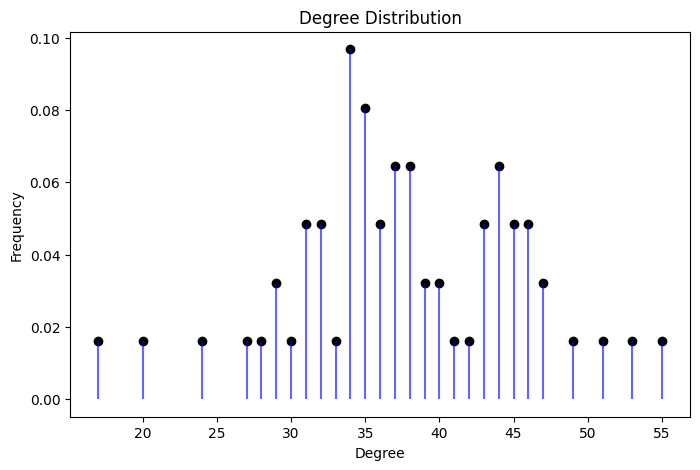

Max degree: 55
Vertices with max degree: [29]


In [27]:
degrees, unique_deg, probs, max_deg, max_vertices = plot_degree_distribution(g)

print(f"Max degree: {max_deg}")
print(f"Vertices with max degree: {max_vertices}")

If we analyse the weighted degree distribution, 

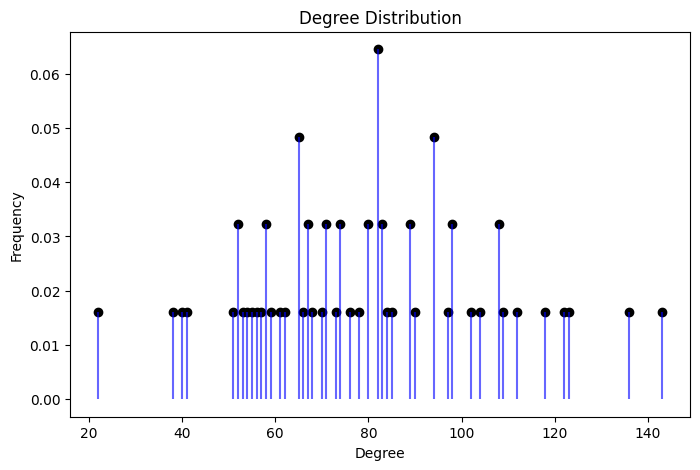

Max degree: 143.0
Vertices with max degree: [29]


In [31]:
degrees_w, unique_deg_w, probs_w, max_deg_w, max_vertices_w = plot_degree_distribution(g, weighted=True)

print(f"Max degree: {max_deg_w}")
print(f"Vertices with max degree: {max_vertices_w}")

Next we are going to compute the diameter.

In [42]:
# Diameter (unweighted)
diameter = g.diameter(directed=False, weights=None)
print("Unweighted diameter:", diameter)

# Get the actual pair of farthest nodes and the path
farthest_pair = g.get_diameter(directed=False, weights=None)
print("Farthest vertices (unweighted):", farthest_pair)


Unweighted diameter: 2
Farthest vertices (unweighted): [0, 1, 39]


As we already seen, our graph is highly connected, so that the unweighted diameter is 2 is quite intuitive. That means that between two indivituals, there is a path of at most 2 (another individual in the middle). But it's not a special case to have a shortest distance of 2, in fact we have 1448 paths of length 2. This means that there are 1448 pairs of individuals that are not directly connected, but they are connected through another individual.

In [ ]:
sp_lengths = g.distances(weights=None)  # or .shortest_paths()

distances = [dist for row in sp_lengths for dist in row if dist != 0]
dist_count = Counter(distances)
print(dist_count)


Counter({1: 2334, 2: 1448})


To compute the weighted diameter, we need to invert the weights, as in our case higher weight means higher connection.

In [63]:
# Add inverse weights (handle division by zero if needed)
g.es["inv_weight"] = [1/w if w != 0 else float("inf") for w in g.es["weight"]]

# Then compute diameter using this new attribute
diameter_w = g.diameter(directed=False, weights="inv_weight")
path_w = g.get_diameter(directed=False, weights="inv_weight")

print("Weighted diameter (based on interaction):", diameter_w)
print("Farthest vertices (based on interaction):", path_w)

Weighted diameter (based on interaction): 1.083333333333333
Farthest vertices (based on interaction): [45, 43, 56, 54]


The longest shortest path is connected through a path whose total inverse-weight is 1.0833.
Notice that using the weights now we obtain a farthest path that contains 3 edges that connect 4 individuals.

In [ ]:
get_weights_of_path(g, path_w)

Original weights on path: [3.0, 2.0, 4.0]
Inverted weights on path: [0.3333333333333333, 0.5, 0.25]
